In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import re
import numpy as np

plt.rcParams['figure.figsize'] = [10, 4]

def extract_numbers(filename, start_line, end_line, search_string):
    # numbers = []
    iters_indices = {}
    current_row = start_line - 1  # start from zero-based index
    
    with open(filename) as f:
        for i, line in enumerate(f):
            line = re.sub(r'\[[^\]]*\]', '', line)
            if i >= start_line-1 and i < end_line:
                loss = re.search(search_string + r'\s*(\d+(?:\.\d+)?)\s*', line)
                if loss:
                    try:
                        iters = int(line.split()[0])
                    except ValueError:
                        print(f'Getting iters error: {line}')
                        continue
                    if iters not in iters_indices:
                        iters_indices[iters] = []
                        
                    iters_indices[iters].append(float(loss.group(1)))
                    # numbers.append(float(error.group(1)))
                    # iters_indices.append(iters)
                    current_row = iters
                else:
                    current_row += 1
    
    x_y = []

    # 获取每个 key 对应的 value 的长度
    value_lengths = [len(iters_indices[key]) for key in iters_indices]

    # 循环遍历每个 n 值
    for n in range(max(value_lengths)):
        x = []
        y = []
        for key in iters_indices:
            if n < len(iters_indices[key]):
                x.append(key)
                y.append(iters_indices[key][n])
        if len(x) > 5:
            x_y.append([x, y])

    return x_y

def plot_numbers(x_y, search_string):
    # 绘制折线图
    fig, ax = plt.subplots()

    # 绘制每条线
    minx = 100000
    maxx = -20000
    miny = 100000
    maxy = -20000
    for i in range(len(x_y)):
        x, y = x_y[i]
        ax.plot(x, y, label=f"Seg. {i}")
        minx = min(x) if min(x) < minx else minx
        maxx = max(x) if max(x) > maxx else maxx
        miny = min(y) if min(y) < miny else miny
        maxy = max(y) if max(y) > maxy else maxy

    # 设置x轴的取值范围
    ax.set_xlim([minx, maxx])

    
    # 动态调整y轴的取值范围和刻度
    min_number = miny
    max_number = maxy
    if min_number == max_number:
        y_min = min_number - 0.5
        y_max = max_number + 0.5
    else:
        range_number = max_number - min_number
        y_min = min_number - 0.1 * range_number
        y_max = max_number + 0.1 * range_number
    y_min = max(0, y_min)
    y_ticks = [round(y_min + i * (y_max - y_min) / 10, 2) for i in range(11)]
    ax.set_ylim([max(0, y_min), y_max])
    ax.set_yticks(y_ticks)

    # x_ticks = np.arange(int(minx/10), int(maxx/10), 3)
    # ax.set_xticks(x_ticks*10)
    ax.set_xticks([0, 20, 50, 90, 140])
    # ax.grid(True, linestyle='--', linewidth=0.5)
    ax.grid(True, which='major', linestyle='-', linewidth=0.5)
    # ax.grid(True, which='major', linestyle='--', linewidth=1, alpha=0.5)

    ax.xaxis.set_minor_locator(plt.MultipleLocator(30))

    # 设置x和y轴的标签和标题
    ax.set_xlabel('Iters')
    ax.set_ylabel('cm or radian')
    ax.set_title(f'{search_string} Error')
    # 显示图形
    plt.legend()
    plt.show()

def plot_error(loss_type, start_line=1, end_line=100000):
    x_y = extract_numbers(filename, start_line, end_line, loss_type) # 查找以 "error_type" 开头的字符串后面的数字
    plot_numbers(x_y, loss_type)

filename = '/home/guest/Documents/Nymeria/20231222_s1_kenneth_fischer_act7_56uvqd/log/2025-03-13T19:12:25__wandb.log'


plot_error('cont')
plot_error('coll')
plot_error('pen')
# plot_error('m2p')
# plot_error('p2m')
plot_error(' sld')
plot_error('csld')
plot_error(' rot')
plot_error('crot')
plot_error(' trans')
plot_error('ctrans')
plot_error(' jts')
plot_error('cjts')
plot_error('prior')
plot_error(' pose')
plot_error('cpose')
plot_error('Loss')
plot_error('Time')

In [22]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
from ipywidgets import interact, IntSlider, FloatSlider, SelectMultiple, Button, HBox, VBox
from matplotlib.animation import FFMpegWriter

def visualize_keypoint_trajectory(pkl_path, img_folder, point_indices=[0], thresh=0.2, save_as_video=False):
    # 1. Load keypoints
    with open(pkl_path, 'rb') as f:
        kpts = pickle.load(f)
    kpts = np.array(kpts)
    num_frames, num_points = kpts.shape[:2]

    # 2. Preload images
    image_list = [f for f in os.listdir(img_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    image_list.sort(key=lambda p: float(os.path.splitext(p)[0]))
    image_paths = [os.path.join(img_folder, fname) for fname in image_list]
    img_list = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in image_paths]

    save_path = os.path.splitext(pkl_path)[0] + ".mp4"
    writer = FFMpegWriter(fps=30) if save_as_video else None

    fig, ax = plt.subplots(figsize=(8, 8))
    
    if save_as_video:
        with writer.saving(fig, save_path, dpi=100):
            def draw(frame_idx=0, thresh=0.2, point_indices=point_indices):
                ax.clear()
                img = img_list[frame_idx]
                img_name = image_list[frame_idx]
                h, w = img.shape[:2]

                ax.imshow(img)
                ax.set_xlim(0, w)
                ax.set_ylim(h, 0)
                ax.text(10, 30, img_name, color='white', fontsize=14, backgroundcolor='black')

                for idx in point_indices:
                    if idx >= num_points:
                        continue
                    good_traj = []
                    bad_traj = []
                    for f in range(frame_idx + 1):
                        x, y, score = kpts[f, idx]
                        x_ = 1024 - y
                        y_ = x
                        if score >= thresh:
                            good_traj.append((x_, y_))
                        else:
                            bad_traj.append((x_, y_))

                    if len(good_traj) > 1:
                        xs, ys = zip(*good_traj)
                        ax.plot(xs, ys, linestyle='dashed', marker='o', label=f"P{idx}")
                    elif len(good_traj) == 1:
                        ax.scatter(*good_traj[0], color='blue', marker='o', s=40)

                    if bad_traj:
                        bx, by = zip(*bad_traj)
                        ax.scatter(bx, by, color='red', marker='x', s=40, label=f"Low P{idx}")

                    x, y, score = kpts[frame_idx, idx]
                    x_ = 1024 - y
                    y_ = x
                    ax.scatter(x_, y_, color='lime', edgecolors='black', linewidths=1.5, s=120, marker='o', label=f"Cur P{idx}")

                ax.set_title(f"Frame {frame_idx}")
                ax.axis('off')
                ax.legend(loc='upper right', fontsize=8)
                writer.grab_frame()

            for i in range(num_frames):
                draw(frame_idx=i, thresh=thresh, point_indices=point_indices)
    
    def draw(frame_idx=0, thresh=0.2, point_indices=point_indices):
        img = img_list[frame_idx]
        img_name = image_list[frame_idx]
        h, w = img.shape[:2]

        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.xlim(0, w)
        plt.ylim(h, 0)
        plt.text(10, 30, img_name, color='white', fontsize=14, backgroundcolor='black')

        for idx in point_indices:
            if idx >= num_points:
                continue
            good_traj = []
            bad_traj = []
            for f in range(frame_idx + 1):
                x, y, score = kpts[f, idx]
                x_ = 1024 - y
                y_ = x
                if score >= thresh:
                    good_traj.append((x_, y_))
                else:
                    bad_traj.append((x_, y_))

            if len(good_traj) > 1:
                xs, ys = zip(*good_traj)
                plt.plot(xs, ys, linestyle='dashed', marker='o', label=f"P{idx}")
            elif len(good_traj) == 1:
                plt.scatter(*good_traj[0], color='blue', marker='o', s=40)

            if bad_traj:
                bx, by = zip(*bad_traj)
                plt.scatter(bx, by, color='red', marker='x', s=40, label=f"Low P{idx}")

            x, y, score = kpts[frame_idx, idx]
            x_ = 1024 - y
            y_ = x
            plt.scatter(x_, y_, color='lime', edgecolors='black', linewidths=1.5, s=120, marker='o', label=f"Cur P{idx}")

        plt.title(f"Frame {frame_idx}")
        plt.axis('off')
        plt.legend(loc='upper right', fontsize=8)
        plt.show()

    frame_slider = IntSlider(min=0, max=num_frames - 1, step=1, value=0, description="Frame", layout={'width': '700px'})
    def move_left(_): frame_slider.value = max(0, frame_slider.value - 1)
    def move_right(_): frame_slider.value = min(num_frames - 1, frame_slider.value + 1)
    left_btn = Button(description="◁", layout={'width': '40px'})
    right_btn = Button(description="▷", layout={'width': '40px'})
    left_btn.on_click(move_left)
    right_btn.on_click(move_right)

    thresh_slider = FloatSlider(min=0.0, max=1.0, step=0.05, value=thresh, description="Thresh")
    point_select = SelectMultiple(options=list(range(num_points)), value=tuple(point_indices), description="Points")

    ui = VBox([
        HBox([left_btn, right_btn, frame_slider]),
        thresh_slider,
        point_select
    ])

    interact(draw, frame_idx=frame_slider, thresh=thresh_slider, point_indices=point_select)
    display(ui)
    return save_path if save_as_video else None


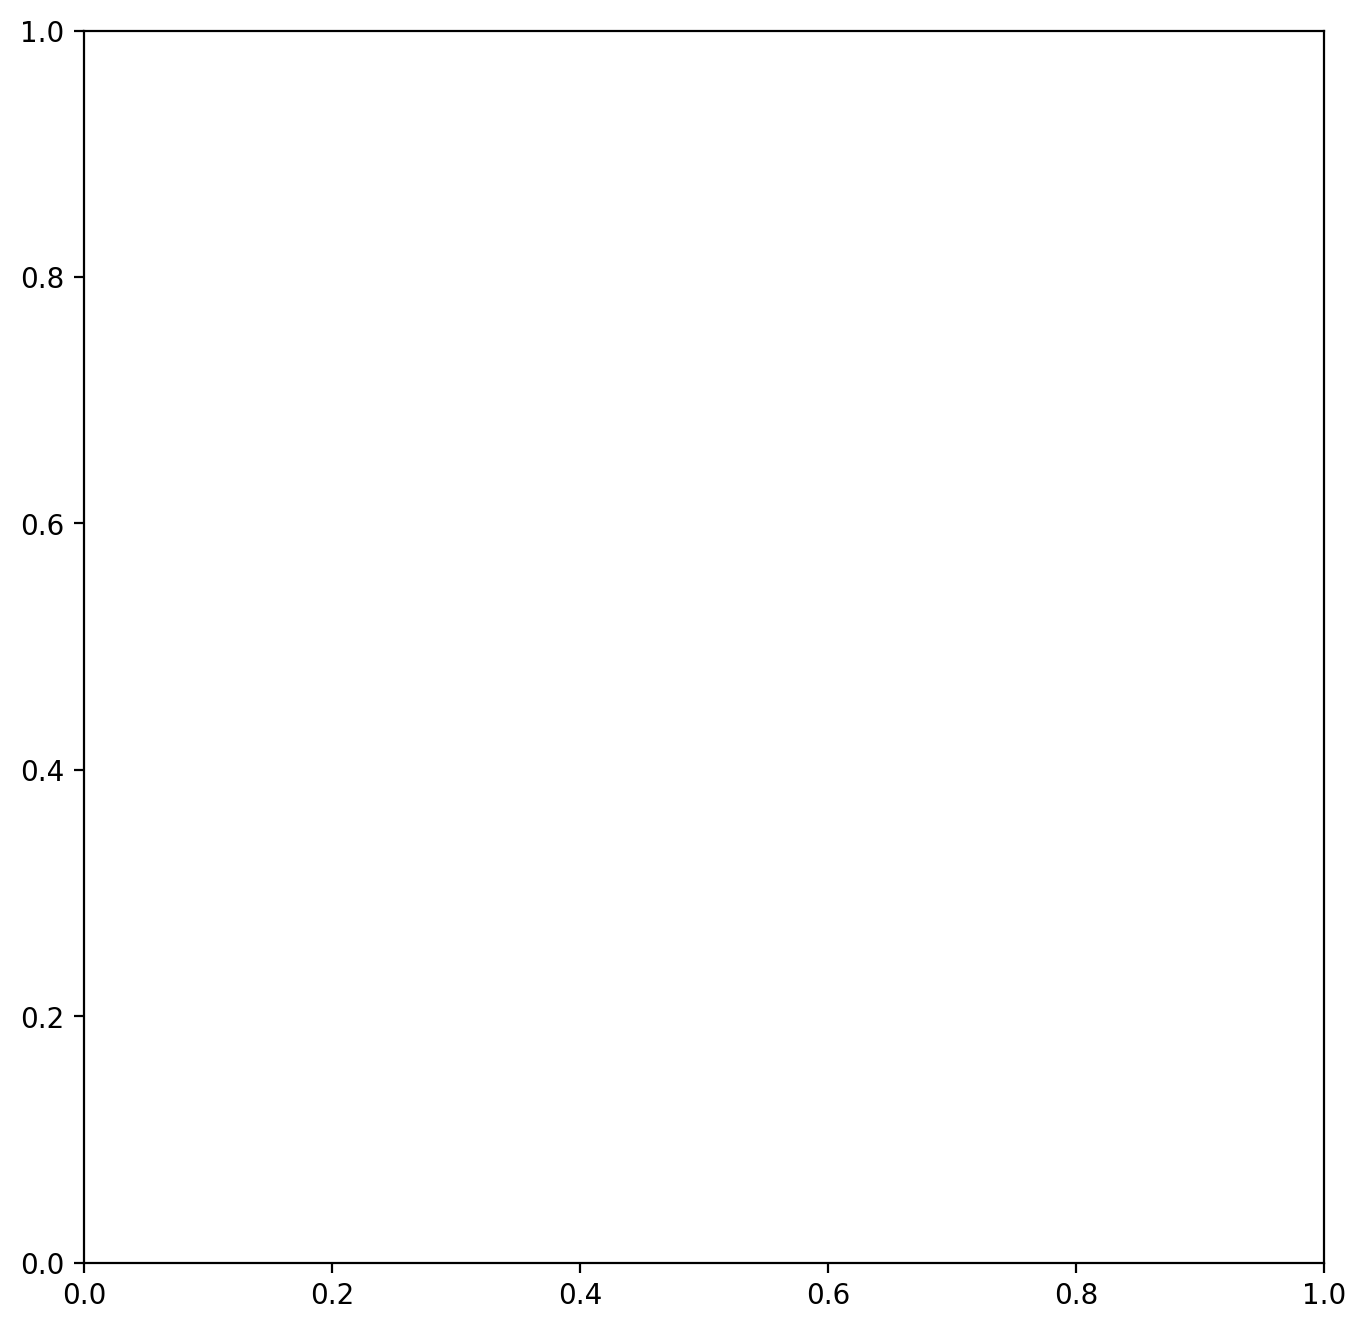

interactive(children=(IntSlider(value=0, description='Frame', layout=Layout(width='700px'), max=940), FloatSli…

In [26]:

visualize_keypoint_trajectory(
    pkl_path='/home/guest/Documents/Nymeria/20231222_s1_kenneth_fischer_act7_56uvqd/recording_head/kpts_imgs_1049_1990.pkl',
    img_folder='/home/guest/Documents/Nymeria/20231222_s1_kenneth_fischer_act7_56uvqd/recording_head/imgs_1049_1990',
    point_indices=[7, 8, 91, 112],  # 要连线的点
    thresh=0.5,                # 显示点的置信度阈值
    save_as_video=True         # 是否保存为视频
)
